In [1]:
from typing import Any

import os
from os.path import join
import shutil
import random

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from settings import *
from validation_model import FaceValidateV1_1

In [2]:
random.seed(42)

all_faces = os.listdir(FACE_DIR)
all_faces = [f'{FACE_DIR}/{face}' for face in all_faces]

random.shuffle(all_faces)

## Manual labeling

In [3]:
def plot_images(image_names):
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax_row in enumerate(ax):
        for j, ax in enumerate(ax_row):
            index = i * 10 + j
            if index < len(image_names):
                img_name = image_names[index]
                img = mpimg.imread(img_name)
                ax.imshow(img)
                title = f'{index+1}  {img_name.split("/")[-1].split(".")[0]}'
                ax.set_title(title, fontsize=8)
                ax.set_xlabel(str(index), fontsize=8, color='blue')
                ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
labels_str = ''

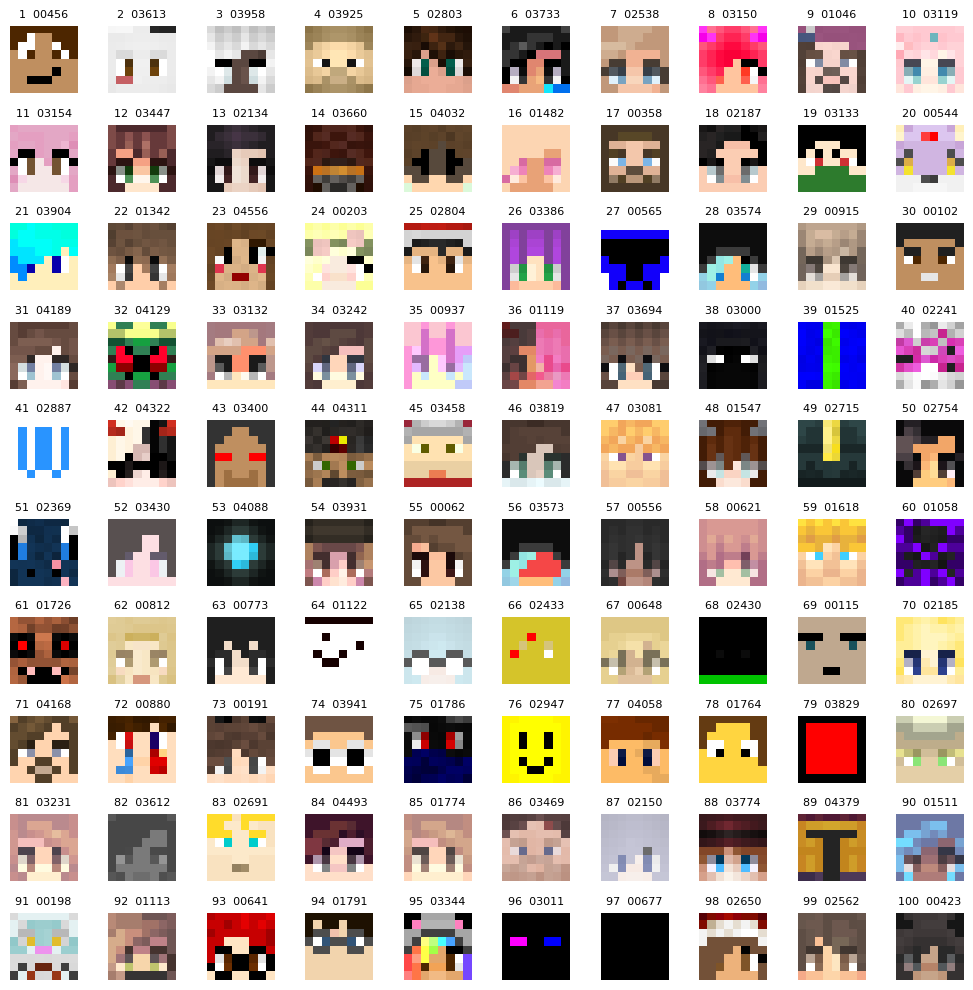

In [141]:
plot_images(all_faces[:100])

In [5]:
labels_str += '1001111111111000110011101101111001101000001111110101011011100110001001101100110111111111010000100111'

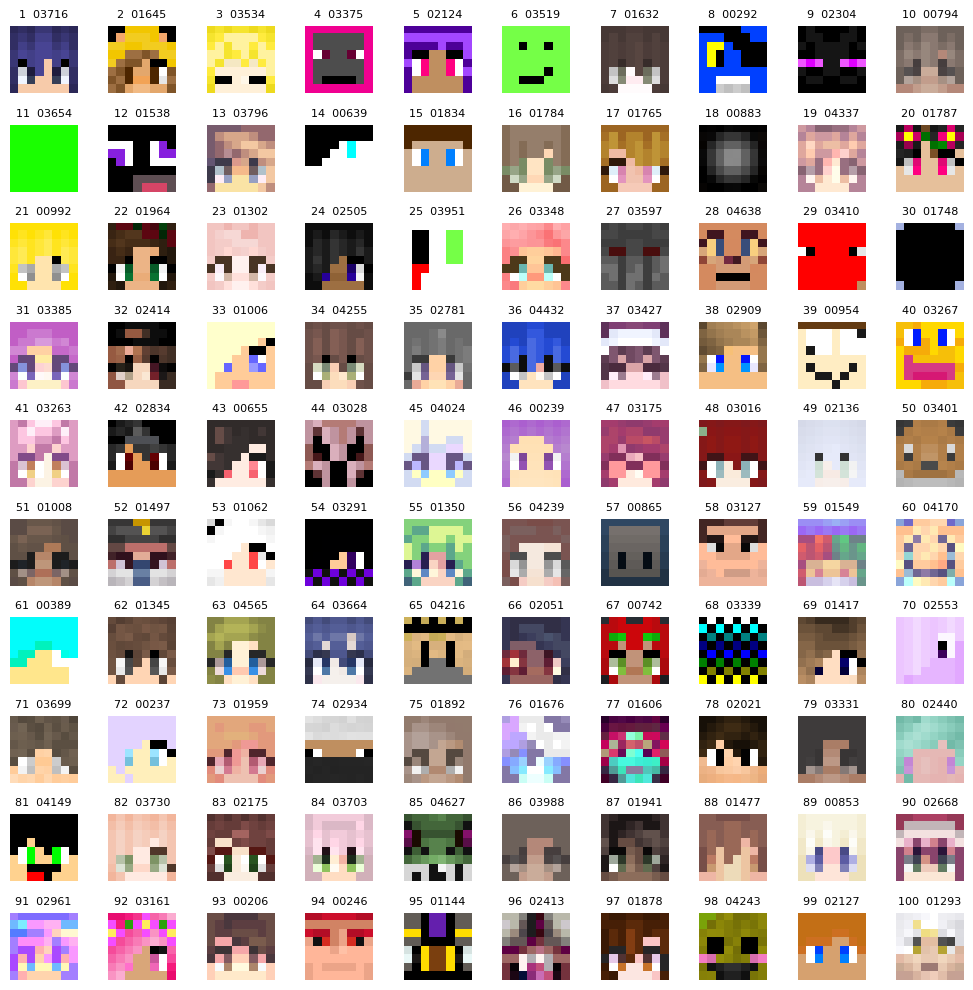

In [143]:
plot_images(all_faces[100:200])

In [6]:
labels_str += '1100101001001001101111110100001111111100111011110010101101000111011010111010011011110110001110001001'

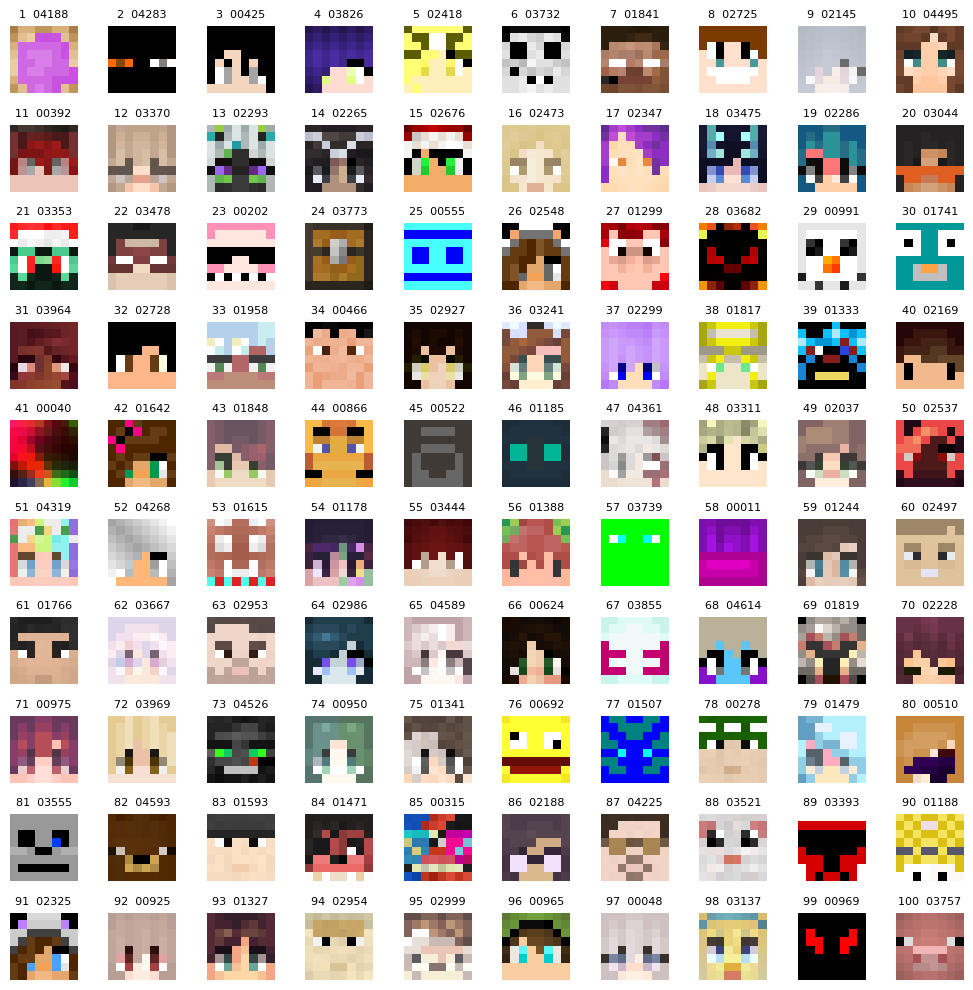

In [145]:
plot_images(all_faces[200:300])

In [7]:
labels_str += '0011101111100111111000000100001111111001011000011011011000111011110000100110001000100000001110011000'

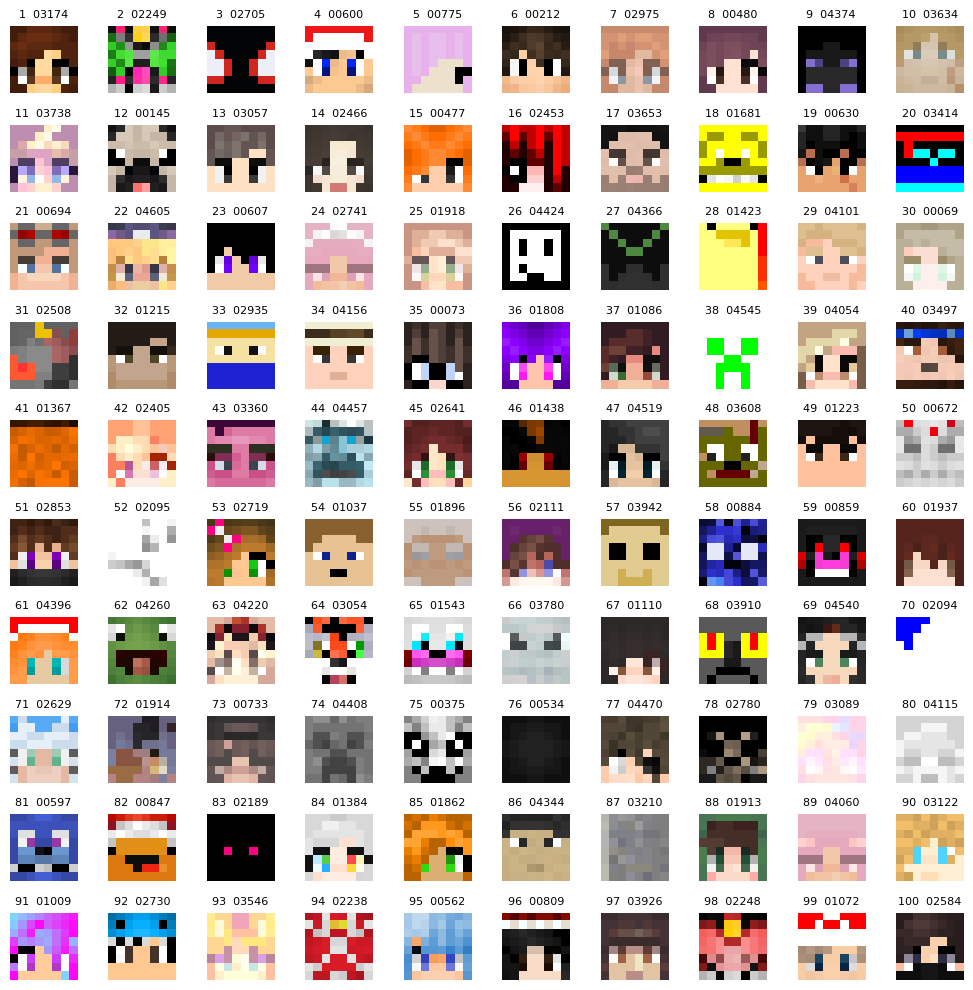

In [147]:
plot_images(all_faces[300:400])

In [8]:
labels_str += '1001011101101110101011111000100101011011011010101010110100001010001010101000000001011101111110111011'

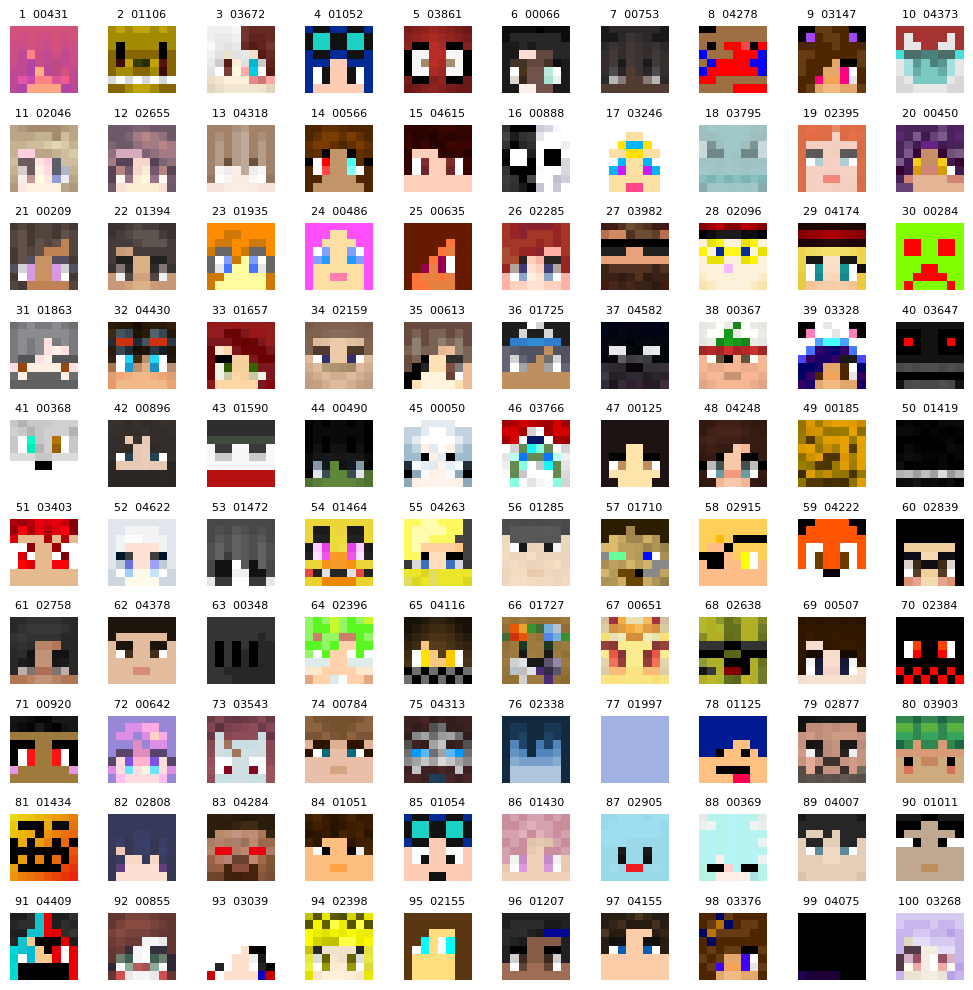

In [149]:
plot_images(all_faces[400:500])

In [9]:
labels_str += '0001001010111110101111111100101111110110010000110001001100001100000010110100011100111100111101111101'

## Data augmentation

In [34]:
labeled_faces = all_faces[:500]
label_list = [int(char) for char in labels_str]

Copy the labeled faces into `SAMPLE_FACE_DIR` path

In [35]:
if not os.path.isdir(SAMPLE_FACE_DIR):
    os.mkdir(SAMPLE_FACE_DIR)

for i, labeled_face_path in enumerate(labeled_faces):
    name = labeled_face_path.split('/')[-1]
    new_path = join(SAMPLE_FACE_DIR, name)
    
    shutil.copy(labeled_face_path, new_path)
    
    labeled_faces[i] = new_path

Save flipped version of valid faces if they're less than 90% symmetric

In [36]:
flipped_faces = []
flipped_labels = []

for i, label in enumerate(label_list):
    if not label:
        continue

    curr_face_img = np.array(Image.open(labeled_faces[i]))
    flipped = np.flip(curr_face_img, axis=1)

    sym_rate = (curr_face_img == flipped).all(axis=2).sum() / 64

    if sym_rate < 0.9:
        # new name
        name = labeled_faces[i]
        name = name.split('/')[-1]
        name = name.split('.')[0]
        new_name = join(SAMPLE_FACE_DIR, name + '_flipped.png')

        # save
        Image.fromarray(flipped).save(new_name)

        # append to arrays
        flipped_faces.append(new_name)
        flipped_labels.append(1)

labeled_faces.extend(flipped_faces)
label_list.extend(flipped_labels)

## Train model

In [37]:
class FaceDataset(Dataset):
    def __init__(self, images, labels) -> None:
        super().__init__()
        self.transform = transforms.ToTensor()

        self.images = images.copy()
        self.labels = labels.copy()
        self.labels = torch.tensor(self.labels,
                                   dtype=torch.float,
                                   device=DEVICE).unsqueeze(1)

    def __getitem__(self, index) -> Any:
        img = Image.open(self.images[index])
        img = self.transform(img).to(device=DEVICE)
        
        return img, self.labels[index]

    def __len__(self):
        return len(self.labels)


In [38]:
# constants
LEARNING_RATE = 0.00005
BATCH_SIZE = 16
NUM_EPOCHS = 200

dataset = FaceDataset(labeled_faces, label_list)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

# model instance
model = FaceValidateV1_1()

# loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

Train the model

In [39]:
losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    for batch_imgs, batch_labels in dataloader:
        
        optimizer.zero_grad()
        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)
        
        # L2 regularization term
        l2_reg = sum(torch.norm(param) for param in model.parameters())
        loss += 0.001 * l2_reg
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    if epoch % 10 == 9:
        print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
        if (epoch + 1) % 20 == 0:
            print()

print("Training complete.")

Epoch 010/200 - Loss: 0.6014	Epoch 020/200 - Loss: 0.4907	
Epoch 030/200 - Loss: 0.4466	Epoch 040/200 - Loss: 0.4291	
Epoch 050/200 - Loss: 0.4224	Epoch 060/200 - Loss: 0.4186	
Epoch 070/200 - Loss: 0.4160	Epoch 080/200 - Loss: 0.4139	
Epoch 090/200 - Loss: 0.4111	Epoch 100/200 - Loss: 0.4097	
Epoch 110/200 - Loss: 0.4071	Epoch 120/200 - Loss: 0.4058	
Epoch 130/200 - Loss: 0.4216	Epoch 140/200 - Loss: 0.4044	
Epoch 150/200 - Loss: 0.4038	Epoch 160/200 - Loss: 0.4033	
Epoch 170/200 - Loss: 0.4028	Epoch 180/200 - Loss: 0.4023	
Epoch 190/200 - Loss: 0.4018	Epoch 200/200 - Loss: 0.4012	
Training complete.


## Evaluation

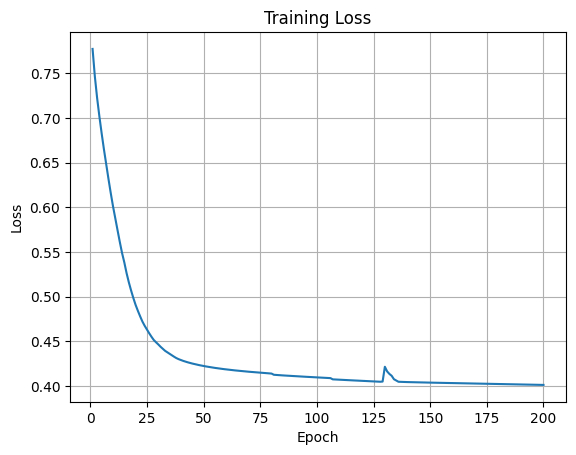

In [40]:
plt.plot(range(1, NUM_EPOCHS + 1), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Run validation prediction on all faces

In [41]:
preds = []

with torch.no_grad():
    model.eval()

    for file_path in all_faces:
        transfom = transforms.ToTensor()

        img = Image.open(file_path)
        img = transfom(img).unsqueeze(0).to(DEVICE)

        y_pred = model(img).item()
        preds.append(y_pred)

preds = np.array(preds)

Display 200 predictions that are not not previously labeled.

We'll only consider predictions greater than or equal to 0.7 to be valid.

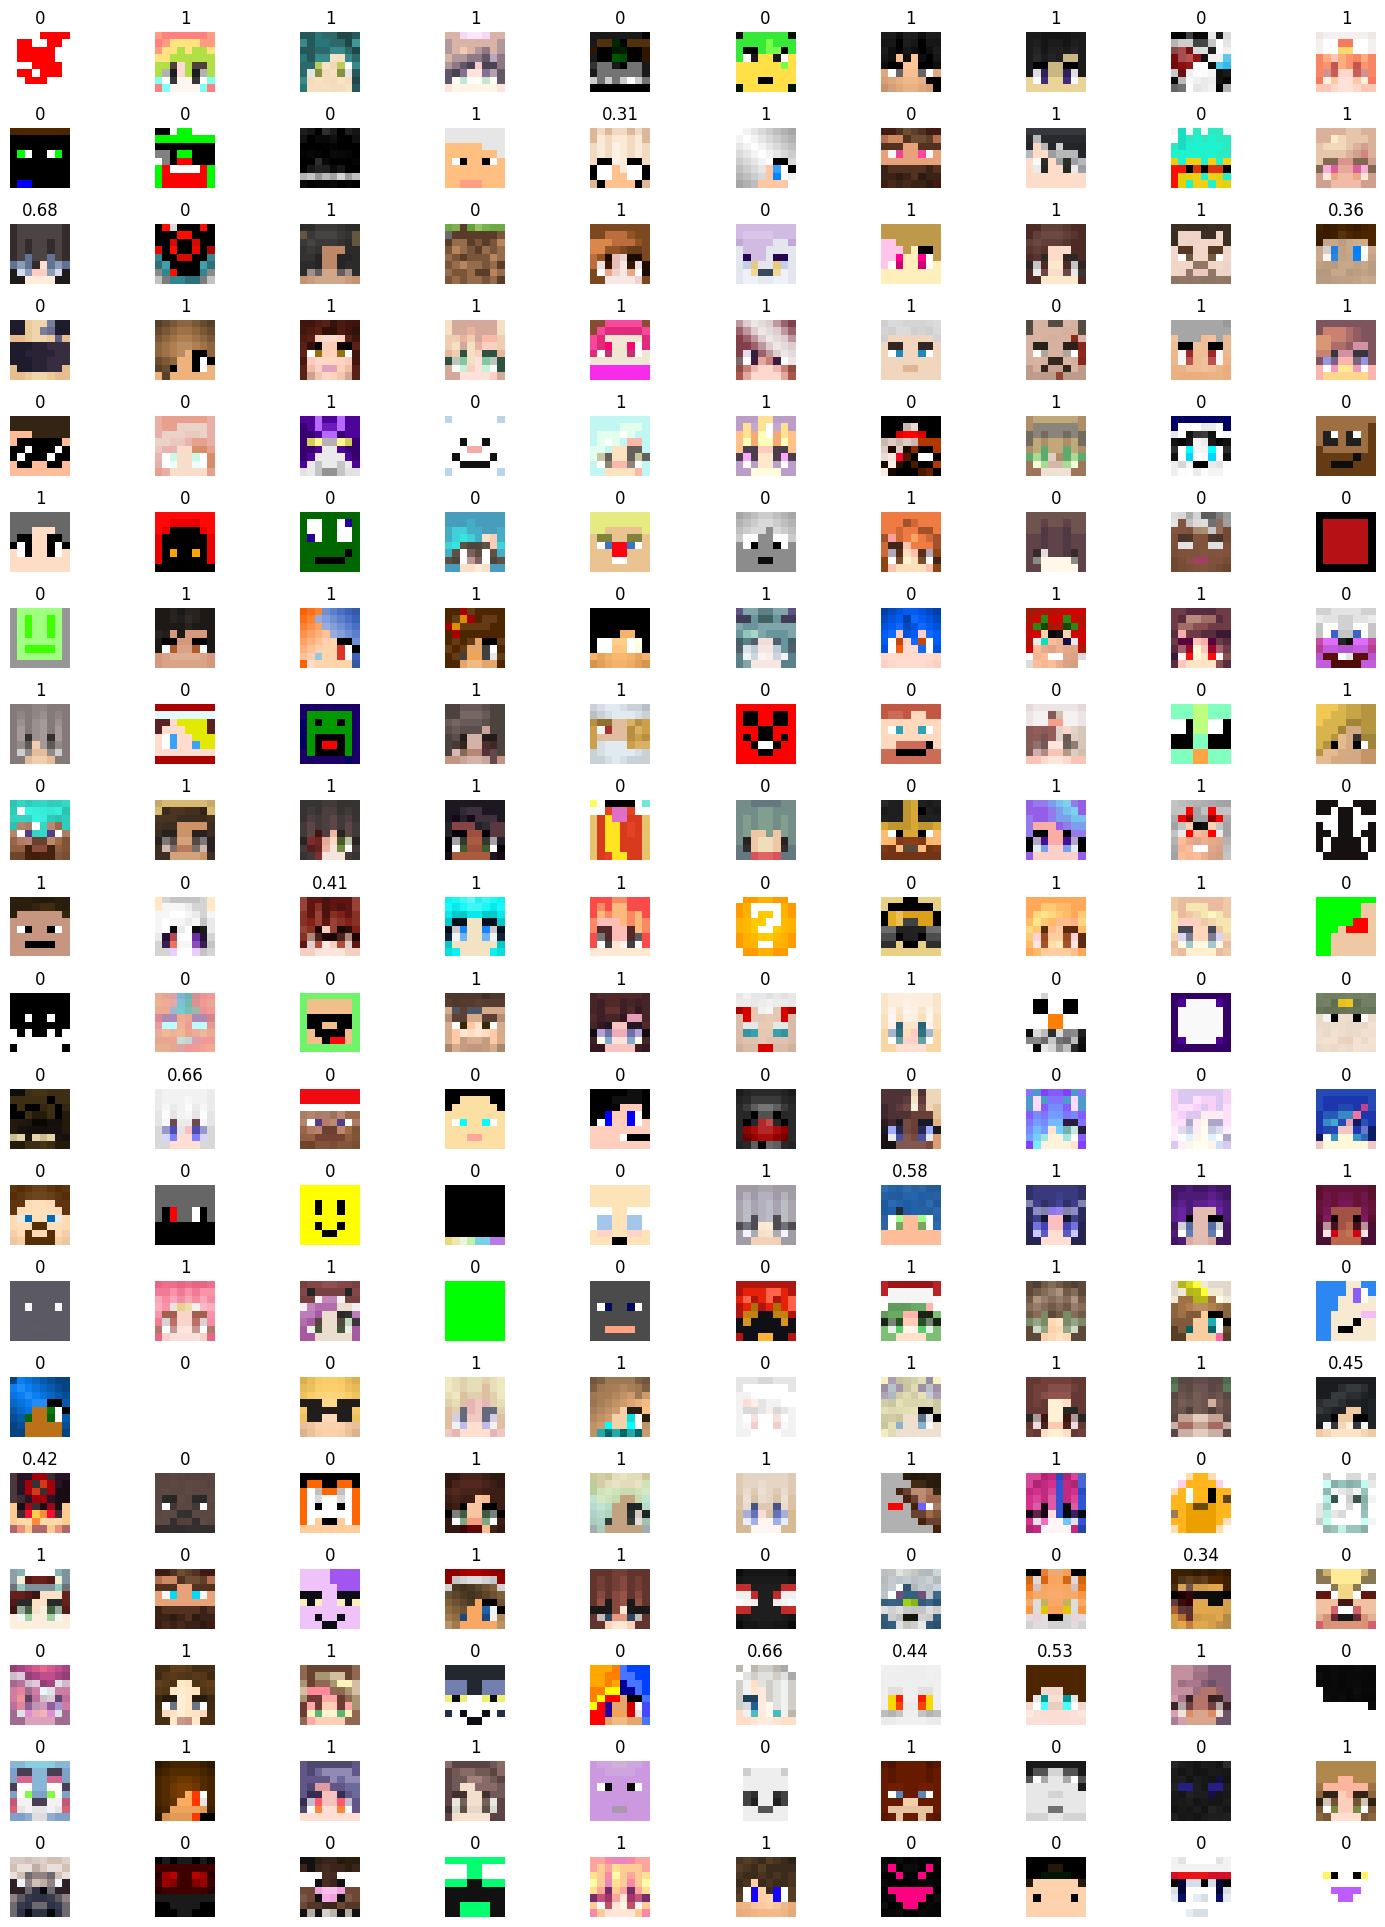

In [42]:
fig, axs = plt.subplots(20, 10, figsize=(15, 20))

labeled_faces = zip(all_faces[700:900], preds[700:900])

for i, (face_file, pred_val) in enumerate(labeled_faces):
    img = mpimg.imread(face_file)

    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')

    if pred_val > 0.7:
        title = '1'
    elif pred_val < 0.3:
        title = '0'
    else:
        title = f'{pred_val:.02f}'

    axs[i // 10, i % 10].set_title(title)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Saving

Save model parameters

In [173]:
torch.save(model.state_dict(), FACE_VALIDATION_MODEL)

Save valid files

In [182]:
valid_face_indexes = np.array(
    np.where(preds >= 0.7)).squeeze()

In [188]:
if not os.path.isdir(VALID_FACE_DIR):
    os.mkdir(VALID_FACE_DIR)

for valid_index in valid_face_indexes:
    file_name = all_faces[valid_index].split('/')[-1]
    new_path = join(VALID_FACE_DIR, file_name)
    shutil.copy(
        all_faces[valid_index],
        new_path
    )